# Modeling

## Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from math import sqrt, pow
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from  lightgbm import LGBMRegressor 
import lightgbm as lgb
from skopt import BayesSearchCV
# check xgboost version
import xgboost as xgb
import time
from bayes_opt import BayesianOptimization

/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.16.0-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/lib/python3/dist-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
df=pd.read_csv("preprocessed.csv", index_col=0)
data=df.copy()

In [9]:
data.columns

Index(['power(kW)', 'trip_distance(km)', 'quantity(kWh)', 'tire_type', 'city',
       'motor_way', 'country_roads', 'driving_style', 'park_heating',
       'avg_speed(km/h)', 'ecr_deviation', 'month', 'weekday', 'day'],
      dtype='object')

In [3]:
X=data.drop('trip_distance(km)',axis=1)
y=data['trip_distance(km)']

## 1. Split Train and test 

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True)

In [128]:
def plotresults(y_test, y_pred_test, tittle):
    x_axis=range(len(y_test))
    plt.plot(x_axis, y_test, linewidth=1, label="original" )
    plt.plot(x_axis, y_pred_test, linewidth=1.1, label="predicted")
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.title(tittle)
    plt.grid(True)
    plt.show()
    
    
    
def calulate_metrics(y_test, y_pred_test):
    mse_rf=mean_squared_error(np.array(y_test), y_pred_test, squared=False)
    rmse_rf = float(format(np.sqrt(mean_squared_error(np.array(y_test), y_pred_test, squared=False)), '.3f'))
    mae= format(mean_absolute_error(np.array(y_test), y_pred_test),'.3f')
    r2_rf=r2_score(y_test,y_pred_test)
    return mse_rf, rmse_rf, mae, r2_rf

def evaluate_metrics(y_test, X_test,regressor_model, tittle):
    y_pred_test=regressor_model.predict(X_test)
    mse_rf, rmse_rf,mae,r2_rf=calulate_metrics(y_test, y_pred_test)
    print('mean_squared_error',mse_rf)
    print('rmse_rf', rmse_rf)
    print('mean_absolute_error', mae)
    print('r2_rf',r2_rf)
    plotresults(y_test,y_pred_test,tittle)

## Decission Tree 


In [170]:

dectree=DecisionTreeRegressor()
dectree.fit(X_train, np.ravel(y_train))

DecisionTreeRegressor()

mean_squared_error 39.14827031291613
rmse_rf 6.257
mean_absolute_error 20.712
r2_rf 0.3832267712523316


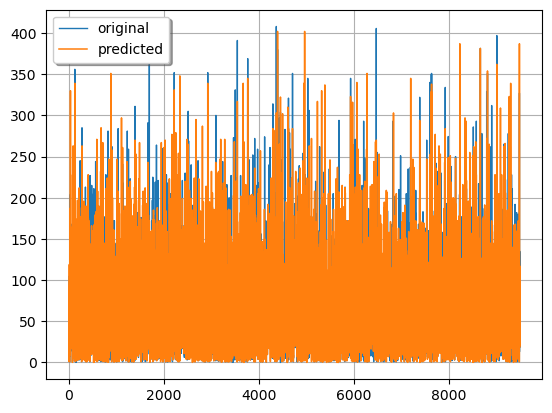

In [169]:
evaluate_metrics(y_test,X_test, dectree)

## Random Forest

### 1.Base Model

In [11]:
rf=RandomForestRegressor(n_estimators=1000)
rf_model=rf.fit(X_train,np.ravel(y_train))


In [12]:
y_pred=rf_model.predict(X_train)

mean_squared_error 28.47615315976754
rmse_rf 5.336
mean_absolute_error 15.266
r2_rf 0.6736654936004605


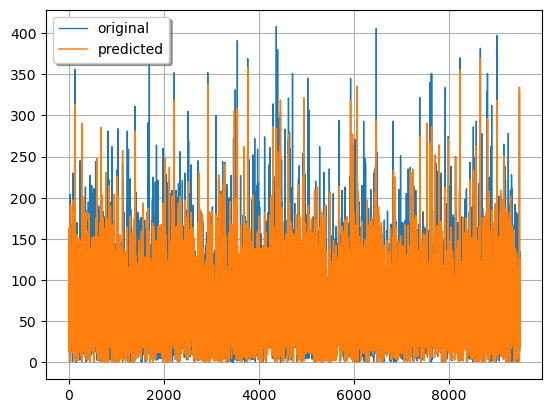

In [156]:
evaluate_metrics(y_test,X_test,rf_model)

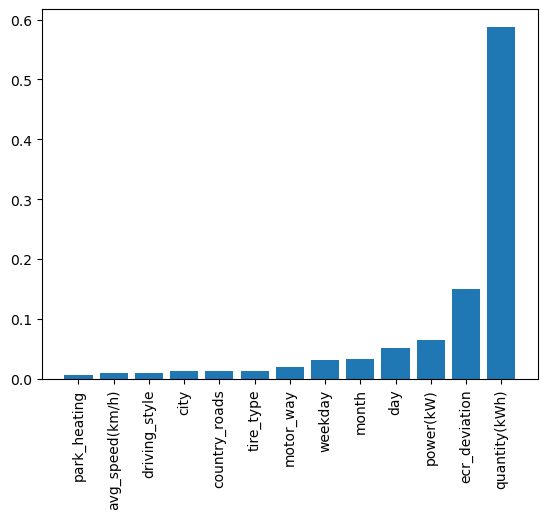

In [43]:
plotfeatureimportance(rf_model)

###  2. Test Data prediction

In [15]:
y_pred_test_rf=rf_model.predict(X_test)

In [20]:
y_pred_test.shape

(9490,)

In [16]:
X.shape

(31631, 13)

In [21]:
y_pred_test.max()

369.3168000000019

In [18]:
y_test.mean()

65.70229715489972

mean_squared_error 28.47615315976754
rmse_rf 5.336
mean_absolute_error 15.266
r2_rf 0.6736654936004605


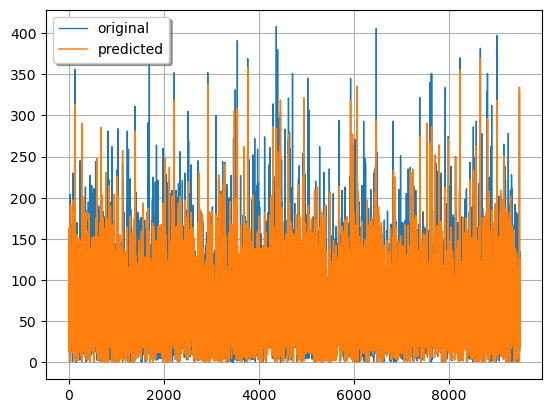

In [157]:
evaluate_metrics(y_test,X_test,rf_model)

In [26]:
# def plotresultsbar(y_test,y_pred_test):
#     fig1=plt.figure(figsize=(5,4))
#     plt.bar(X_test['power(kW)'],y_test, color='red', label='y_test')
#     plt.bar(X_test['power(kW)'],y_pred_test, color='blue', label='y_pred_test')
#     plt.ylim([0,500])
#     plt.xlabel('power')
#     plt.ylabel('Range')
#     plt.title(' Range versus power')
#     plt.show()


In [78]:
# def plotlinegraph(y_test, y_pred_test):
#     fig1=plt.figure(figsize=(5,4))
#     sns.lineplot(x=X_test['power(kW)'],y=y_test, color='red', label='y_test')
#     sns.lineplot(x=X_test['power(kW)'],y=y_pred_test, color='blue', label='y_pred_test')
#     plt.ylim([0,500])
#     plt.xlabel('power')
#     plt.ylabel('Range')
#     plt.title(' Range versus power')
#     plt.show()


###  3. Tuned Random Forest

In [31]:
rf_cv=RandomForestRegressor()
skfold= StratifiedKFold(n_splits=5, shuffle=True)

In [32]:
params_grid={
 'n_estimators': [i for i in range(1,500)],
 'bootstrap': [True, False],
 'max_depth':[ i for i in range(1,14)],
 'min_samples_leaf': [ i for i in range(1,10)],
 'min_samples_split': [ i for i in range(2,10)],
 'criterion': ['squared_error']
 }

In [33]:
rf_random = RandomizedSearchCV(estimator = rf_cv, param_distributions = params_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train,np.ravel(y_train))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=False, criterion=squared_error, max_depth=6, min_samples_leaf=7, min_samples_split=3, n_estimators=1; total time=   0.1s
[CV] END bootstrap=False, criterion=squared_error, max_depth=6, min_samples_leaf=7, min_samples_split=3, n_estimators=1; total time=   0.0s
[CV] END bootstrap=False, criterion=squared_error, max_depth=6, min_samples_leaf=7, min_samples_split=3, n_estimators=1; total time=   0.0s
[CV] END bootstrap=False, criterion=squared_error, max_depth=6, min_samples_leaf=7, min_samples_split=3, n_estimators=1; total time=   0.0s
[CV] END bootstrap=False, criterion=squared_error, max_depth=6, min_samples_leaf=7, min_samples_split=3, n_estimators=1; total time=   0.0s
[CV] END bootstrap=True, criterion=squared_error, max_depth=4, min_samples_leaf=4, min_samples_split=6, n_estimators=203; total time=   4.1s
[CV] END bootstrap=True, criterion=squared_error, max_depth=4, min_samples_leaf=4, min_samples_s

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['squared_error'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   random_state=42, verbose=2)

In [34]:
rf_random.best_params_

{'n_estimators': 354,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'max_depth': 13,
 'criterion': 'squared_error',
 'bootstrap': True}

In [35]:
cv_res=pd.DataFrame(rf_random.cv_results_)

In [36]:
cv_res[cv_res.rank_test_score==1]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
94,18.733622,0.214154,0.227574,0.016336,354,9,2,13,squared_error,True,"{'n_estimators': 354, 'min_samples_split': 9, ...",0.698677,0.657093,0.675926,0.669594,0.634042,0.667066,0.021327,1


mean_squared_error 27.971027940585664
rmse_rf 5.289
mean_absolute_error 15.866
r2_rf 0.685140202282486


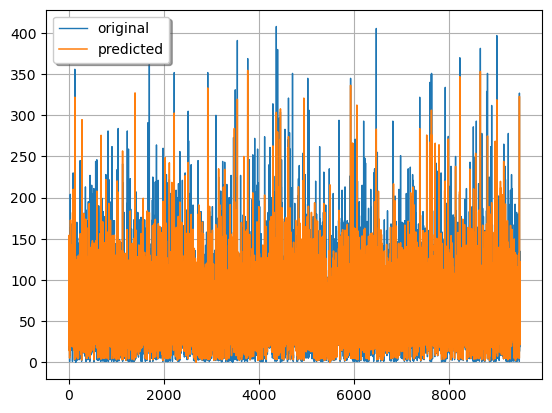

In [159]:
evaluate_metrics(y_test,X_test,rf_random.best_estimator_)

## XGBoost

### Basic Model 

In [111]:
params = {
            'objective':'reg:squarederror',
    #         'max_depth': 4,
    #         'alpha': 10,
    #         'learning_rate': 1.0,
    #         'n_estimators':100,
    #         'subsample':0.8,  
    #         'eta':0.1,
    #   #      'n_parallel_tree':10,
    #         'alpha':0.0,
    #         'gamma':0.0,
    #         'lambda':0.01,
    #         'booster':'gbtree'
        }  

In [161]:
  
# Instantiation
xgb_r = xgb.XGBRegressor(**params)
# Fitting the model
xgb_r.fit(X_train,np.ravel(y_train))

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

mean_squared_error 28.806865641510008
rmse_rf 5.367
mean_absolute_error 15.988
r2_rf 0.6660415997401514


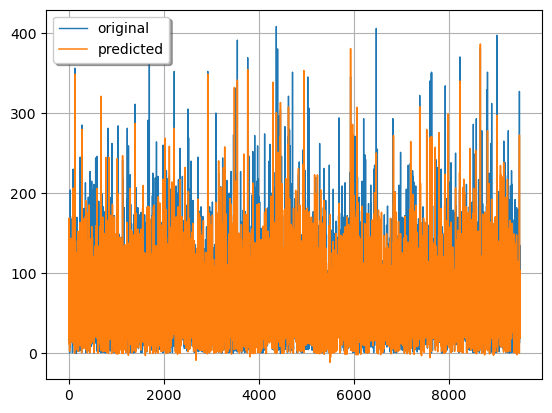

In [162]:
evaluate_metrics(y_test,X_test,xgb_r)

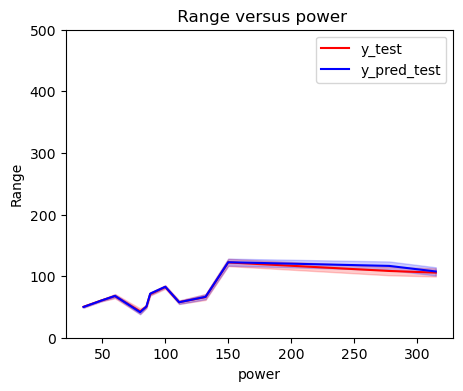

In [37]:
plotlinegraph(y_test, y_test_pred_xgb)

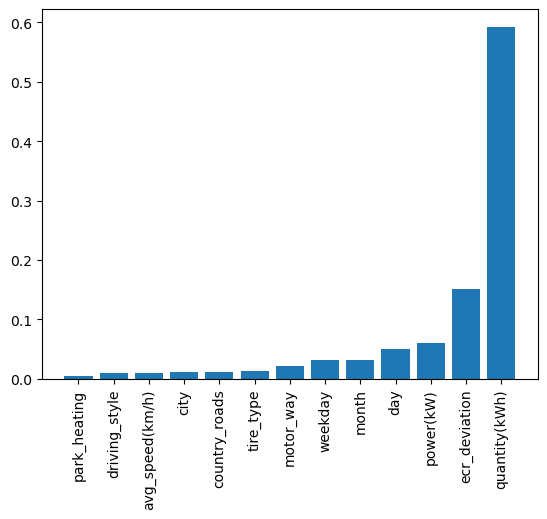

In [47]:
plotfeatureimportance(rf_model)


### 2. Tuning Params 

In [12]:
skf = StratifiedKFold(n_splits=5,
                      shuffle=True, 
                      random_state=0)

In [135]:
space={   
       'objective':['reg:squarederror'],
       'max_depth': [1, 2,3,4,5,6,7,8,9,10],
       'n_estimators': [i for i in range(1,500)],
        'learning_rate':[0.01,0.1, 1.0] ,
        'subsample':[0.5,.6,.7,0.8],  
        'eta':[0.1],
        'lambda':[0.01],
        'booster':['gbtree']
    }
xgb_r_tun = xgb.XGBRegressor( )
xgb_cv = RandomizedSearchCV(estimator=xgb_r_tun,param_distributions=space, cv=5,n_iter=100)
xgb_cv=xgb_cv.fit(X_train, y_train)

In [160]:
# def report_performance(optimizer, X, y, title="model"):
#     start = time()
#     optimizer.fit(X, y)
        
#     d=pd.DataFrame(optimizer.cv_results_)
#     best_score = optimizer.best_score_
#     best_score_std = d.iloc[optimizer.best_index_].std_test_score
#     best_params = optimizer.best_params_
#     print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
#            + u"\u00B1"+" %.3f") % (time() - start, 
#                                    len(optimizer.cv_results_['params']),
#                                    best_score,
#                                    best_score_std))    
#     print('Best parameters:')
#     print()
#     return best_params

In [163]:
score=pd.DataFrame(xgb_cv.cv_results_).query('rank_test_score==1')

In [164]:
score

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_objective,param_n_estimators,param_max_depth,param_learning_rate,param_lambda,...,param_booster,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
58,3.24293,1.091118,0.011784,0.000194,0.6,reg:squarederror,398,7,0.01,0.01,...,gbtree,"{'subsample': 0.6, 'objective': 'reg:squareder...",0.708879,0.66782,0.683894,0.678543,0.645861,0.676999,0.020592,1


mean_squared_error 28.03136293618191
rmse_rf 5.294
mean_absolute_error 15.733
r2_rf 0.6837803986035791


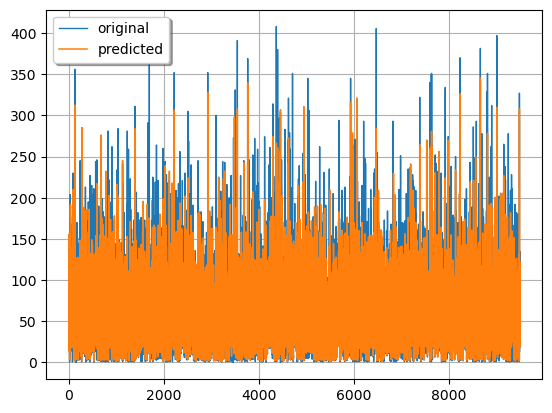

In [166]:
evaluate_metrics(y_test, X_test, xgb_cv.best_estimator_)

In [ ]:
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform'),
                 'max_depth': Integer(2, 12),
                 'subsample': Real(0.1, 1.0, 'uniform'),
                 'colsample_bytree': Real(0.1, 1.0, 'uniform'), # subsample ratio of columns by tree
                 'reg_lambda': Real(1e-9, 100., 'uniform'), # L2 regularization
                 'reg_alpha': Real(1e-9, 100., 'uniform'), # L1 regularization
                 'n_estimators': Integer(50, 5000)
        

In [ ]:
# from bayes_opt import BayesianOptimization
# # Gradient Boosting Machine
# def gbm_cl_bo(max_depth, max_features, learning_rate, n_estimators, subsample):
#     params_gbm = {}
#     params_gbm['max_depth'] = round(max_depth)
#     params_gbm['max_features'] = max_features
#     params_gbm['learning_rate'] = learning_rate
#     params_gbm['n_estimators'] = round(n_estimators)
#     params_gbm['subsample'] = subsample
#     xgb_r = xgb.XGBRegressor( objective='reg:squarederror', )
#     scores = cross_val_score(GradientBoostingClassifier(random_state=123, **params_gbm),
#                              X_train, y_train, scoring=acc_score, cv=5).mean()
#     score = scores.mean()
#     return score
# # Run Bayesian Optimization
# start = time.time()
# params_gbm ={
#     'max_depth':(3, 10),
#     'max_features':(0.8, 1),
#     'learning_rate':(0.01, 1),
#     'n_estimators':(80, 150),
#     'subsample': (0.8, 1)
# }
# gbm_bo = BayesianOptimization(gbm_cl_bo, params_gbm, random_state=111)
# gbm_bo.maximize(init_points=20, n_iter=4)
# print('It takes %s minutes' % ((time.time() - start)/60))

## Light GBM 

In [178]:
lgbm_model=LGBMRegressor( objective = "regression")

In [179]:
lgbm_model.fit(X_train,np.ravel(y_train))

LGBMRegressor(objective='regression')

mean_squared_error 28.00581794356237
rmse_rf 5.292
mean_absolute_error 15.742
r2_rf 0.6843564780998556


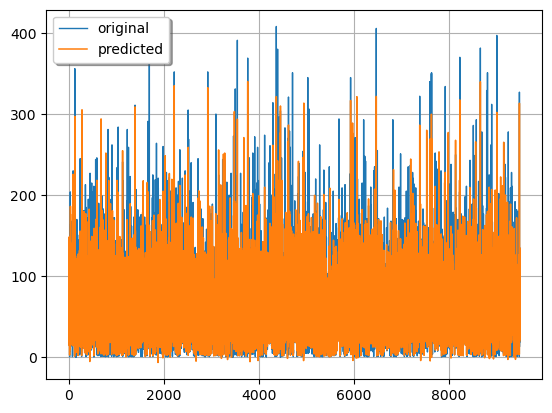

In [180]:
evaluate_metrics(y_test, X_test, lgbm_model)

In [182]:
lgbm_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': 'regression',
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

### Tune Light GBM

# importing modules
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

In [176]:
lgbm_params = {
        "objective" : ["regression"],
        "metric" :[ "mse"],
        'boosting_type': ['gbdt'],
      
         "max_depth": 8,
         "learning_rate" : [0.005, 0.01, 0.02, 0.1],
        'min_child_samples': [2,5,10,20],
        'n_estimators': [i for i in range(50,500)],
        'num_leaves': [i for i in range(20,50)],
         'min_child_weight':[ 0.001, 0.002,0.003],
         "bagging_seed" : 42,
        "verbosity" : 1,
        "seed": 42,
        

    }



## NN 

In [34]:
# importing modules
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Activation
import matplotlib.pyplot as plt

In [12]:
from sklearn.preprocessing import StandardScaler
feature_scaler = StandardScaler()
label_scaler = StandardScaler()

# Fit on Training Data
feature_scaler.fit(X_train)
label_scaler.fit(np.array(y_train).reshape(-1, 1))

# Transform both training and testing data
train_features = feature_scaler.transform(X_train)
test_features = feature_scaler.transform(X_test)
train_labels = label_scaler.transform(np.array(y_train).reshape(-1, 1))
test_labels = label_scaler.transform(np.array(y_test).reshape(-1, 1))

In [13]:
from tensorflow.keras import layers

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [14]:
# Now let's create a Deep Neural Network to train a regression model on our data.
model = Sequential([
    layers.Dense(32, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

2022-11-22 10:32:23.731025: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 10:32:23.731367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 10:32:23.731545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-11-22 10:32:23.731702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-11-22 10:32:23.731848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [15]:
model.compile(optimizer="RMSProp",
              loss="mean_squared_error")

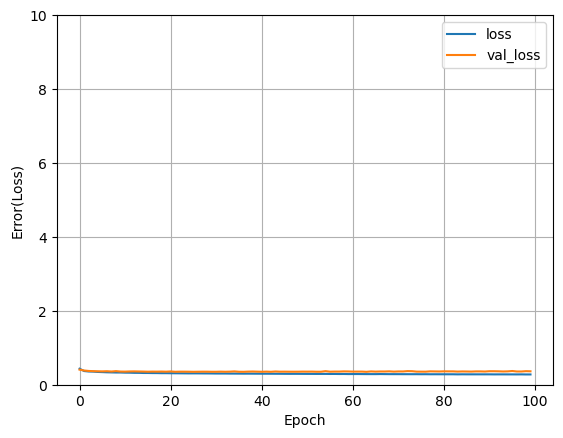

In [17]:

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0,10])
plt.xlabel('Epoch')
plt.ylabel('Error(Loss)')
plt.legend()
plt.grid(True)

## NN 

In [35]:
len(X_train.columns)

13

In [147]:
from keras.layers import Dense
model = Sequential()
model.add(Dense(10, input_shape = (13,), activation= 'relu'))
model.add(Dense(8, activation= 'relu'))
model.add(Dense(6, activation= 'relu'))
model.add(Dense(4, activation= 'relu'))
model.add(Dense(2, activation= 'relu'))
model.add(Dense(units=1, activation='relu'))

In [148]:
from keras import optimizers
sgd = optimizers.SGD()
model.compile(optimizer="RMSProp", loss = 'mean_squared_error', metrics= ['mse', 'mae'])
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_115 (Dense)           (None, 10)                140       
                                                                 
 dense_116 (Dense)           (None, 8)                 88        
                                                                 
 dense_117 (Dense)           (None, 6)                 54        
                                                                 
 dense_118 (Dense)           (None, 4)                 28        
                                                                 
 dense_119 (Dense)           (None, 2)                 10        
                                                                 
 dense_120 (Dense)           (None, 1)                 3         
                                                                 
Total params: 323
Trainable params: 323
Non-trainable

In [149]:
model.fit(X_train, y_train, batch_size= 40, epochs=100, verbose= 0)
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)


297/297 [==============================] - 0s 648us/step


In [150]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Train Accuracy: ",mean_squared_error(y_train, train_pred))
print("Test Accuracy: ",mean_squared_error(y_test, test_pred))

Train Accuracy:  861.1497487589914
Test Accuracy:  917.4352741086143


297/297 [==============================] - 0s 653us/step
mean_squared_error 30.289194015500218
rmse_rf 5.504
mean_absolute_error 18.079
r2_rf 0.6383869860534139


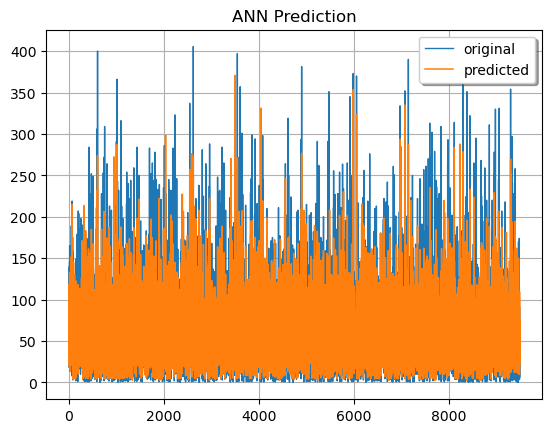

In [151]:
evaluate_metrics(y_test,X_test, model,'ANN Prediction')

In [100]:
y_test.mean()

66.33566912539507

In [152]:
test_pred.mean()

63.1643

In [154]:
(66.3356-63.1647)/66.3356

0.04780087916593799